# Forecast

For practical implementation:
https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html

For theoretical knowledge of spline:
https://timodenk.com/blog/cubic-spline-interpolation/


In [3]:
# Author: Mathieu Blondel
#         Jake Vanderplas
#         Christian Lorentzen
#         Malte Londschien
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.pipeline import make_pipeline
import os
import matplotlib.lines as mlines
import seaborn as sns
from distfit import distfit

In [5]:

desktop = os.path.join(os.path.join(os.environ['USERPROFILE']), 'Desktop') 
#print(os.getcwd())
This_file_path = os.getcwd()
total_string_len = len(This_file_path)
#print(total_string_len)

string_len_to_remove = len("Data Examination")
#print(string_len_to_remove)

path = This_file_path[0:(total_string_len-string_len_to_remove)]
#print(path)
path_processed_data = path + "Processed_data\\"
#print(path_processed_data)

# Set up FCR-D forecast. Mean for the past 5 days. Base case
- At D-2 it is past 5 days, meaning 7 days from what to predict.
- At D-1 it is the past 5 days, meaning 6 days from what to predict

In [23]:
data = pd.read_csv(path_processed_data + 'real.csv') # Change path
data = data.drop(columns=["Hour"])
True_data = data
True_data_arr = True_data.to_numpy()


In [24]:
Forecasts = ["Spot","FD1_down","FD2_down","FD1_up","FD2_up","FD1_up_percentage","FD2_up_percentage","FD1_down_percentage","FD2_down_percentage","FD_act_up","FD_act_down"]
Total_length_test = len(data["FD1_down"])
forecasted_data = np.zeros(( Total_length_test, len(Forecasts) ))  # (Specific Forecasts, Data size, number of total forecasts )
print(np.shape(forecasted_data))

(10920, 11)


In [25]:
index_FD1_up_percentage = Forecasts.index("FD1_up_percentage")
index_FD1_down_percentage = Forecasts.index("FD1_down_percentage")

D_2_list = [2,3,4,5,6]
start_idx = D_2_list[-1]*24

for col in data.columns:
    index = Forecasts.index(col) # Get the index
    
    # Run mean procedure

    # As the volumes need to add up to 100% then is it only the D-1 which has been forecasted as t
    if 'percentage' in col:
            if "FD2" in col:
                if "up" in col:
                    forecasted_data[:,index] = 1 - forecasted_data[:,index_FD1_up_percentage]
                else:
                    forecasted_data[:,index] = 1 - forecasted_data[:,index_FD1_down_percentage]
                    #forecasted_data.loc[h, col] = 1 - forecasted_data.loc[h, 'FD1_down_percentage']
            else:
                for h in range(start_idx,Total_length_test):
                    value = 0
                    for hd in D_2_list:

                        #print(data.loc[h+8760-hd*24, col])
                        #print(h+8760-hd*24)
                        value = value + data.loc[h-hd*24, col]
                    
                    forecasted_data[h,index] = value/len(D_2_list)

    else:

        for h in range(start_idx,Total_length_test):
            value = 0
            for hd in D_2_list:

                #print(data.loc[h+8760-hd*24, col])
                #print(h+8760-hd*24)
                value = value + data.loc[h-hd*24, col]
            
            forecasted_data[h,index] = value/len(D_2_list)


    print("Forecasts for ", col, " ended")

            
    

Forecasts for  Spot  ended
Forecasts for  FD1_down  ended
Forecasts for  FD2_down  ended
Forecasts for  FD1_up  ended
Forecasts for  FD2_up  ended
Forecasts for  FD1_up_percentage  ended
Forecasts for  FD2_up_percentage  ended
Forecasts for  FD1_down_percentage  ended
Forecasts for  FD2_down_percentage  ended
Forecasts for  FD_act_up  ended
Forecasts for  FD_act_down  ended


In [27]:
F_len = np.size(forecasted_data[:,:],1) # Number of features
T_len = np.size(forecasted_data[:,:],0) # length of test data
Saved_Info = np.zeros((F_len ,(1+1+1+1) ) ) # Number of different forecast noise, Features and col = (noise type, MAE, MedianEA, Std) 
F = data.columns
for f in range(0,F_len): # For each type of forecast, spot, FD2 Down so forth..

    errors = (True_data_arr[start_idx:,f] - forecasted_data[start_idx:,f])

    MAE_h  =np.abs(errors)
    #MAPE_h = np.abs( (errors) / (True_data_arr[:,f]) ) * 100
    
    #MAPE = np.mean(MAPE_h)
    MAE = np.mean(MAE_h)
    ME = np.mean(errors)
    
    #Median_APE = np.median(MAPE_h)
    Median_AE = np.median(MAE_h)
    Median_E = np.median(errors)

    #Std_APE = np.std(MAPE_h)
    Std_AE = np.std(MAE_h)
    Std_E  = np.std(errors)

        
    # Save the proper data
    Saved_Info[f,1] = ME
    Saved_Info[f,2] = Median_E
    Saved_Info[f,3] = Std_E

print("Forecast ",F[0],"(",np.round(Saved_Info[0,1]), np.round(Saved_Info[0,2]), np.round(Saved_Info[0,3]),")", "   ",F[1],"(",np.round(Saved_Info[1,1]), np.round(Saved_Info[1,2]), np.round(Saved_Info[1,3]),")", "   ",F[2],"(",np.round(Saved_Info[2,1]), np.round(Saved_Info[2,2]), np.round(Saved_Info[2,3]),")", "   ",F[3],"(",np.round(Saved_Info[3,1]), np.round(Saved_Info[3,2]), np.round(Saved_Info[3,3]),")", "   ",F[4],"(",np.round(Saved_Info[4,1]), np.round(Saved_Info[4,2]), np.round(Saved_Info[4,3]),")")



Forecast  Spot ( -0.0 5.0 105.0 )     FD1_down ( -0.0 -3.0 88.0 )     FD2_down ( -0.0 -1.0 13.0 )     FD1_up ( 0.0 -1.0 49.0 )     FD2_up ( -0.0 -1.0 9.0 )


# Create a csv file for forecasted values

In [28]:
F = data.columns
# change forecasted_data_3D to a dataframe
df_forecast = pd.DataFrame(forecasted_data[:,:], columns=F)

#Create csv
csv_name_path = path_processed_data+"forecast_all1.csv"
df_forecast.to_csv(csv_name_path,index=False)

# Create the perfect forecast as well:
csv_name_path = path_processed_data+"forecast_all0.csv"
data.to_csv(csv_name_path,index=False)

# Set up all the other forecasts

In [24]:
data = pd.read_csv(path_processed_data + 'real.csv') # Change path
data = data.drop(columns=["Hour"])
True_data = data
True_data_arr = True_data.to_numpy()
Total_length_test = len(data["FD1_down"])


In [25]:
#Forecasts = ["Spot","FD1_down","FD2_down","FD1_up","FD2_up"]
Forecasts = ["Spot","FD1_down","FD2_down","FD1_up","FD2_up","FD1_up_percentage","FD2_up_percentage","FD1_down_percentage","FD2_down_percentage","FD_act_up","FD_act_down"]
back_view_lst = [0,7,21,41]
back_view = [i for i in back_view_lst]
start_idx = [i*24 for i in back_view_lst]
#start_idx = [0,6*24,40*24,100*24]
forecasted_data_3D_test = np.zeros(( Total_length_test, len(Forecasts), len(back_view) ))  # (Specific Forecasts, Data size, number of total forecasts )
for f,col in enumerate(data[Forecasts].columns):
    index = Forecasts.index(col) # Get the index
    print(col)
    

    for n,back in enumerate(back_view):

        if back == 0:
            D_list = [0]
        else:
            D_list = [i for i in range(2,back)]

        for h in range(start_idx[n],Total_length_test):
            value = 0
            for hd in D_list:
                
                value = value + data.loc[h-hd*24, col]
                #print(value)
            
            forecasted_data_3D_test[h,index,n] = value/len(D_list)

Spot
FD1_down
FD2_down
FD1_up
FD2_up
FD1_up_percentage
FD2_up_percentage
FD1_down_percentage
FD2_down_percentage
FD_act_up
FD_act_down


In [26]:
N_len = np.size(forecasted_data_3D_test[:,:,:],2) # Number of forecasts
F_len = np.size(forecasted_data_3D_test[:,:,:],1) # Number of features
T_len = np.size(forecasted_data_3D_test[:,:,:],0) # length of test data
Saved_Info = np.zeros((N_len,F_len ,(1+1+1+1+1) ) ) # Number of different forecast noise, Features and col = (noise type, MAE, MedianEA, Std) 
F = data.columns
for n in range(0,N_len): # For each forecast factor

    for f in range(0,F_len): # For each type of forecast, spot, FD2 Down so forth..
        
        errors = (True_data_arr[:,f] - forecasted_data_3D_test[:,f,n])

        MAE_h  =np.abs(errors)
        #MAPE_h = np.abs( (errors) / (True_data_arr[:,f]) ) * 100
        
        #MAPE = np.mean(MAPE_h)
        MAE = np.mean(MAE_h)
        ME = np.mean(errors)

        negative_values = errors[errors < 0]
        ME_neg = np.mean(negative_values)

        positive_values = errors[errors > 0]
        ME_pos = np.mean(positive_values)

        
        #Median_APE = np.median(MAPE_h)
        Median_AE = np.median(MAE_h)
        Median_E = np.median(errors)

        #Std_APE = np.std(MAPE_h)
        Std_AE = np.std(MAE_h)
        Std_E  = np.std(errors)
        Std_E_neg = np.std(negative_values)
        Std_E_pos = np.std(positive_values)
    
        #print(len(negative_values))
        #print(len(positive_values))
        # Save the proper data
        Saved_Info[n,f,0] = n
        Saved_Info[n,f,1] = ME_neg
        Saved_Info[n,f,2] = Std_E_neg
        Saved_Info[n,f,3] = ME_pos
        Saved_Info[n,f,4] = Std_E_pos


#print(Saved_Info)


for n in range(0,N_len):
    print("Forecast ",n, "    ", "   ",F[1],"(",np.round(Saved_Info[n,1,1]), np.round(Saved_Info[n,1,2]), np.round(Saved_Info[n,1,3]),np.round(Saved_Info[n,1,4]),")", "   ",F[2],"(","(",np.round(Saved_Info[n,2,1]), np.round(Saved_Info[n,2,2]),")","(", np.round(Saved_Info[n,2,3]),np.round(Saved_Info[n,2,4]),")",")", "   ",F[3],"(",np.round(Saved_Info[n,3,1]), np.round(Saved_Info[n,3,2]), np.round(Saved_Info[n,3,3]),np.round(Saved_Info[n,3,4]),")", "   ",F[4],"(",np.round(Saved_Info[n,4,1]), np.round(Saved_Info[n,4,2]), np.round(Saved_Info[n,4,3]),np.round(Saved_Info[n,4,4]),")")



Forecast  0          FD1_down ( nan nan nan nan )     FD2_down ( ( nan nan ) ( nan nan ) )     FD1_up ( nan nan nan nan )     FD2_up ( nan nan nan nan )
Forecast  1          FD1_down ( -26.0 51.0 46.0 115.0 )     FD2_down ( ( -5.0 7.0 ) ( 10.0 17.0 ) )     FD1_up ( -25.0 30.0 31.0 50.0 )     FD2_up ( -5.0 6.0 9.0 12.0 )
Forecast  2          FD1_down ( -25.0 35.0 55.0 130.0 )     FD2_down ( ( -8.0 9.0 ) ( 16.0 20.0 ) )     FD1_up ( -25.0 27.0 36.0 53.0 )     FD2_up ( -10.0 9.0 17.0 15.0 )
Forecast  3          FD1_down ( -27.0 27.0 58.0 131.0 )     FD2_down ( ( -11.0 10.0 ) ( 18.0 22.0 ) )     FD1_up ( -28.0 27.0 39.0 54.0 )     FD2_up ( -16.0 11.0 23.0 17.0 )


In [27]:
F = data.columns
# change forecasted_data_3D to a dataframe
for n in range(0,N_len): # For each forecast factor
    df_forecast = pd.DataFrame(forecasted_data_3D_test[:,:,n], columns=F)

    #Create csv
    csv_name_path = path_processed_data+"forecast_all"+str(n)+".csv"
    print(csv_name_path)
    df_forecast.to_csv(csv_name_path,index=False)



c:\Users\Daniel  BV\Desktop\Thesis\lightenup\Processed_data\forecast_all0.csv
c:\Users\Daniel  BV\Desktop\Thesis\lightenup\Processed_data\forecast_all1.csv
c:\Users\Daniel  BV\Desktop\Thesis\lightenup\Processed_data\forecast_all2.csv
c:\Users\Daniel  BV\Desktop\Thesis\lightenup\Processed_data\forecast_all3.csv


# Plot for Appendix

In [28]:
data = pd.read_csv(path_processed_data + 'real.csv') # Change path
data = data.drop(columns=["Hour"])
True_data = data
True_data_arr = True_data.to_numpy()
Total_length_test = len(data["FD1_down"])


In [29]:
Forecasts = ["Spot","FD1_down","FD2_down","FD1_up","FD2_up"]
#Forecasts = ["Spot","FD1_down","FD2_down","FD1_up","FD2_up","FD1_up_percentage","FD2_up_percentage","FD1_down_percentage","FD2_down_percentage","FD_act_up","FD_act_down"]
back_view = [0,6,40,100]
back_view = [i for i in range(0,42,3)]
start_idx = [i*24 for i in range(0,42,3)]
#start_idx = [0,6*24,40*24,100*24]
forecasted_data_3D_test = np.zeros(( Total_length_test, len(Forecasts), len(back_view) ))  # (Specific Forecasts, Data size, number of total forecasts )
for f,col in enumerate(data[Forecasts].columns):
    index = Forecasts.index(col) # Get the index
    print(col)
    

    for n,back in enumerate(back_view):

        if back == 0:
            D_list = [0]
        else:
            D_list = [i for i in range(2,back)]

        for h in range(start_idx[n],Total_length_test):
            value = 0
            for hd in D_list:
                
                value = value + data.loc[h-hd*24, col]
                #print(value)
            
            forecasted_data_3D_test[h,index,n] = value/len(D_list)

Spot
FD1_down
FD2_down
FD1_up
FD2_up


In [30]:
N_len = np.size(forecasted_data_3D_test[:,:,:],2) # Number of forecasts
F_len = np.size(forecasted_data_3D_test[:,:,:],1) # Number of features
T_len = np.size(forecasted_data_3D_test[:,:,:],0) # length of test data
Saved_Info = np.zeros((N_len,F_len ,(1+1+1+1+1+1) ) ) # Number of different forecast noise, Features and col = (noise type, MAE, MedianEA, Std) 
F = data.columns
for n in range(0,N_len): # For each forecast factor

    for f in range(0,F_len): # For each type of forecast, spot, FD2 Down so forth..
        
        errors = (True_data_arr[:,f] - forecasted_data_3D_test[:,f,n])

        MAE_h  =np.abs(errors)
        #MAPE_h = np.abs( (errors) / (True_data_arr[:,f]) ) * 100
        
        #MAPE = np.mean(MAPE_h)
        MAE = np.mean(MAE_h)
        ME = np.median(errors)

        # Seperate into negative and positive
        # Not accepted
        negative_values = errors[errors < 0]
        ME_neg = np.median(np.abs(negative_values))

        positive_values = errors[errors >= 0]
        ME_pos = np.median(positive_values)

        non_accepted = (len(negative_values))/len(errors) *100

        #Median_APE = np.median(MAPE_h)
        Median_AE = np.median(MAE_h)
        Median_E = np.median(errors)

        #Std_APE = np.std(MAPE_h)
        Std_AE = np.std(MAE_h)
        Std_E_neg = np.std(negative_values)
        Std_E_pos = np.std(positive_values)
            
        # Save the proper data
        Saved_Info[n,f,0] = n
        Saved_Info[n,f,1] = non_accepted
        Saved_Info[n,f,2] = ME_pos
        Saved_Info[n,f,3] = ME_neg
        Saved_Info[n,f,4] = Std_E_neg
        Saved_Info[n,f,5] = Std_E_pos
        
        MAE = np.mean(MAE_h)
        



#print(Saved_Info)


for n in range(0,N_len):
    print("Forecast d:",back_view[n], "    ",F[0],"(",np.round(Saved_Info[n,0,1]), np.round(Saved_Info[n,0,2]), np.round(Saved_Info[n,0,3]),")", "   ",F[1],"(",np.round(Saved_Info[n,1,1]), np.round(Saved_Info[n,1,2]), np.round(Saved_Info[n,1,3]),")", "   ",F[2],"(",np.round(Saved_Info[n,2,1]), np.round(Saved_Info[n,2,2]), np.round(Saved_Info[n,2,3]),")", "   ",F[3],"(",np.round(Saved_Info[n,3,1]), np.round(Saved_Info[n,3,2]), np.round(Saved_Info[n,3,3]),")", "   ",F[4],"(",np.round(Saved_Info[n,4,1]), np.round(Saved_Info[n,4,2]), np.round(Saved_Info[n,4,3]),")")



Forecast d: 0      Spot ( 0.0 0.0 nan )     FD1_down ( 0.0 0.0 nan )     FD2_down ( 0.0 0.0 nan )     FD1_up ( 0.0 0.0 nan )     FD2_up ( 0.0 0.0 nan )
Forecast d: 3      Spot ( 50.0 62.0 58.0 )     FD1_down ( 52.0 7.0 6.0 )     FD2_down ( 61.0 2.0 2.0 )     FD1_up ( 50.0 14.0 14.0 )     FD2_up ( 61.0 3.0 2.0 )
Forecast d: 6      Spot ( 47.0 63.0 62.0 )     FD1_down ( 61.0 11.0 8.0 )     FD2_down ( 65.0 3.0 2.0 )     FD1_up ( 54.0 14.0 15.0 )     FD2_up ( 61.0 4.0 3.0 )
Forecast d: 9      Spot ( 46.0 61.0 59.0 )     FD1_down ( 64.0 13.0 9.0 )     FD2_down ( 64.0 3.0 3.0 )     FD1_up ( 56.0 15.0 14.0 )     FD2_up ( 60.0 6.0 3.0 )
Forecast d: 12      Spot ( 46.0 63.0 62.0 )     FD1_down ( 66.0 15.0 9.0 )     FD2_down ( 64.0 5.0 3.0 )     FD1_up ( 56.0 16.0 14.0 )     FD2_up ( 59.0 7.0 4.0 )
Forecast d: 15      Spot ( 45.0 62.0 63.0 )     FD1_down ( 67.0 17.0 10.0 )     FD2_down ( 63.0 6.0 4.0 )     FD1_up ( 57.0 17.0 14.0 )     FD2_up ( 59.0 9.0 5.0 )
Forecast d: 18      Spot ( 45.0 61.0

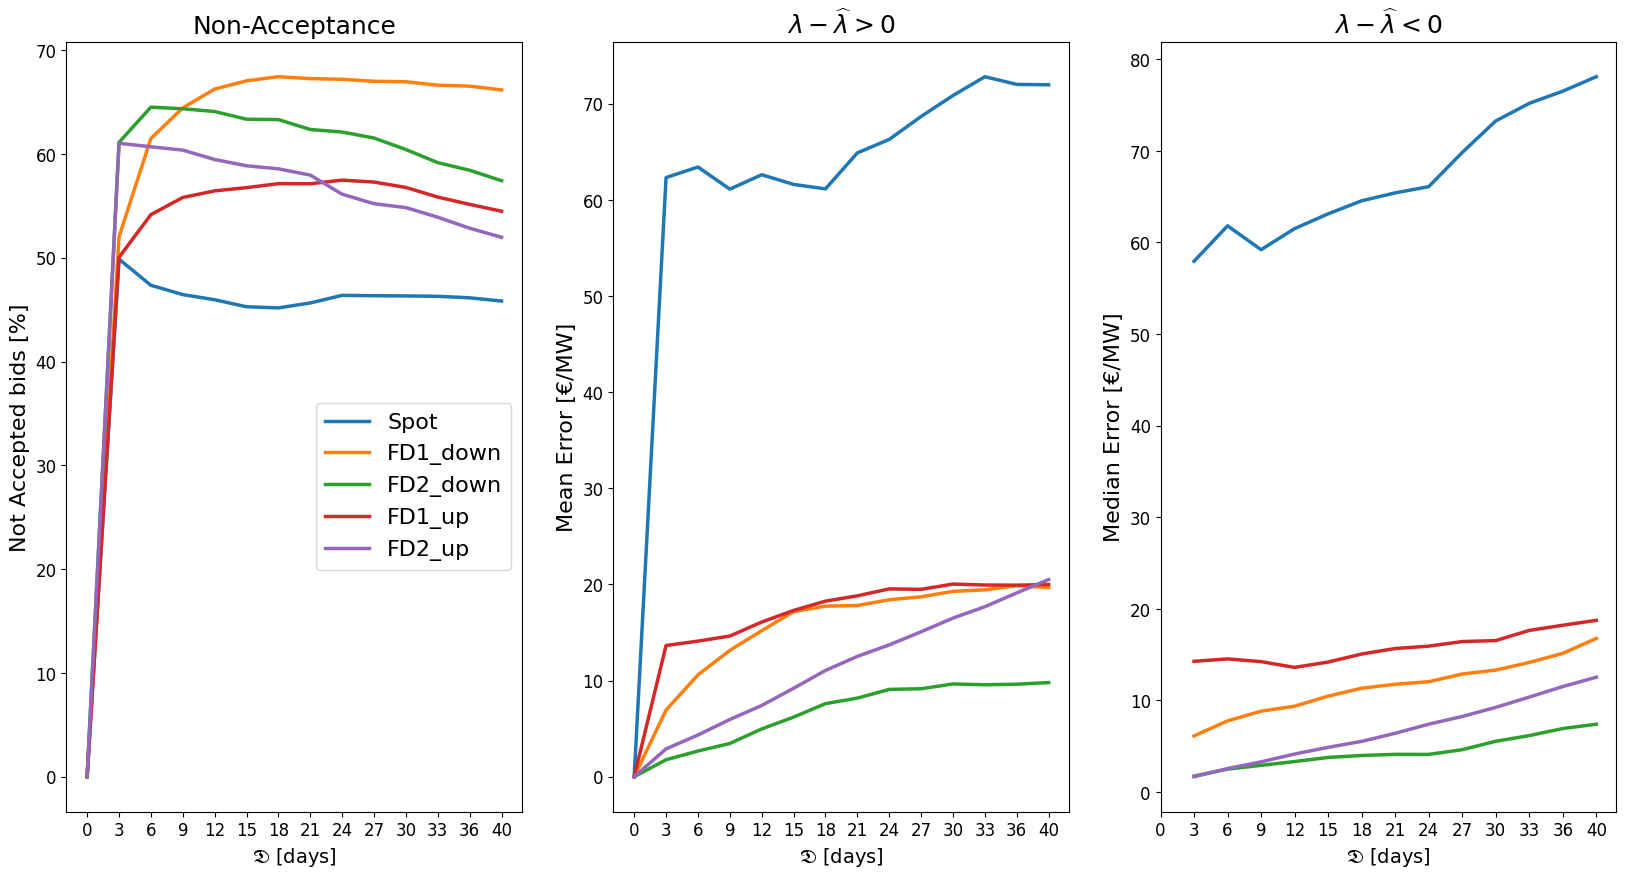

In [34]:
import matplotlib.pyplot as plt
import numpy as np

x = back_view

Forecasts = ["Spot","FD1_down", "FD2_down", "FD1_up", "FD2_up"]
linewidth = 2.5
marker_size = 14  # Adjust the marker size as desired
ME_neg_pos = [1, 2,3]
y_labels = ['Not Accepted bids [%]','Mean Error [€/MW]','Median Error [€/MW]']
titles = ['Non-Acceptance','$\lambda - \widehat{\lambda} > 0$','$\lambda - \widehat{\lambda} < 0$']
fig, axs = plt.subplots(1, 3, figsize=(20, 10))  # Create subplots

# Plot for each feature on respective subplots
for i, e in enumerate(ME_neg_pos):
    ax = axs[i]  # Select the current subplot
    for f in range(len(Forecasts)):
        E = Saved_Info[:, f, e]
        ax.plot(x, E, linestyle='-', label=Forecasts[f], linewidth=linewidth, markersize=marker_size)

    ax.set_ylabel(y_labels[i], fontsize=16)
    
    ax.tick_params(axis='y', which='major', labelsize=12)

    ax.set_xlabel('$\mathfrak{D}$ [days]', fontsize=14)  # Set x-label for the last subplot
        
    # Set xticks and labels for the current subplot
    ax.set_xticks(x)  # Set the xticks locations
    ax.set_xticklabels([0,3,6,9,12,15,18,21,24,27,30,33,36,40], fontsize=12)  # Set the xtick labels
    ax.set_title(titles[i],fontsize=18)  # Set the title of the subplot
axs[0].legend(loc='lower right', bbox_to_anchor=(1.0, 0.3), prop={'size': 16})  # Locate the legend to the middle in the right part of the plot

plt.savefig('forecast_mean_D.pdf', format="pdf", bbox_inches="tight")
plt.show()


# Non-linear Feature transformation

In [4]:
from sklearn.preprocessing import PolynomialFeatures
transformer = PolynomialFeatures(degree=2, include_bias=False)
data = pd.read_csv(path_processed_data + 'real.csv') # Change path
cols = ["Spot","FD1_down","FD2_down","FD1_up","FD2_up","FD1_up_percentage","FD2_up_percentage","FD1_down_percentage","FD2_down_percentage","FD_act_down","FD_act_up"]
Chosen_cols = ["Spot","FD1_down","FD2_down","FD1_up","FD2_up","FD1_up_percentage","FD2_up_percentage","FD1_down_percentage","FD2_down_percentage","FD_act_down","FD_act_up","Spot^2","Spot FD1_down","Spot FD2_down","Spot FD1_up","Spot FD2_up","FD1_down^2","FD1_down FD2_down","FD1_down FD1_up","FD1_down FD2_up","FD2_down^2","FD2_down FD1_up","FD2_down FD2_up","FD1_up^2","FD1_up FD2_up","FD2_up^2"]
# Assuming Chosen_cols is your list
modified_cols = [col.replace(" ", "_") for col in Chosen_cols]


transformed_data = transformer.fit_transform(data[cols])
transformed_cols = transformer.get_feature_names_out(cols).tolist() # Output it as a list and not numpy array
transformed_modified_cols = [col.replace(" ", "_") for col in transformed_cols]
transformed_df = pd.DataFrame(transformed_data, columns=transformed_modified_cols)
transformed_df[modified_cols].to_csv(path_processed_data + "features.csv", sep=',', header=True, index_label='Hour')

print(transformed_df)

            Spot  FD1_down  FD2_down    FD1_up    FD2_up  FD1_up_percentage   
0      46.599998  42.42105  33.89313   1.95478  49.18715           0.034299  \
1      41.330002  42.42105  33.89313   1.95492  49.33709           0.012891   
2      42.180000  43.36842  33.89313   1.96262  49.71026           0.013107   
3      44.369999  42.42105  33.89313   1.96222  49.45940           0.013804   
4      37.669998  41.78947  33.89313   1.95644  49.52272           0.009886   
...          ...       ...       ...       ...       ...                ...   
10915  92.500000   9.40653  18.32412  27.71766  30.13228           0.179322   
10916  48.080002   8.94430  18.28115  27.30695  29.82065           0.177119   
10917  40.930000   9.03942  18.33040  27.34312  29.82881           0.143390   
10918  35.849998   8.99331  18.35501  27.38835  29.55485           0.136610   
10919  30.040001   8.95851  18.37732  27.26135  29.58701           0.146441   

       FD2_up_percentage  FD1_down_percentage  FD2_

In [5]:
from sklearn.preprocessing import PolynomialFeatures
data = pd.read_csv(path_processed_data + 'forecast_all1.csv') # Change path
transformer = PolynomialFeatures(degree=2, include_bias=False)
cols = ["Spot","FD1_down","FD2_down","FD1_up","FD2_up","FD1_up_percentage","FD2_up_percentage","FD1_down_percentage","FD2_down_percentage","FD_act_down","FD_act_up"]
Chosen_cols = ["Spot","FD1_down","FD2_down","FD1_up","FD2_up","FD1_up_percentage","FD2_up_percentage","FD1_down_percentage","FD2_down_percentage","FD_act_down","FD_act_up","Spot^2","Spot FD1_down","Spot FD2_down","Spot FD1_up","Spot FD2_up","FD1_down^2","FD1_down FD2_down","FD1_down FD1_up","FD1_down FD2_up","FD2_down^2","FD2_down FD1_up","FD2_down FD2_up","FD1_up^2","FD1_up FD2_up","FD2_up^2"]
# Assuming Chosen_cols is your list
modified_cols = [col.replace(" ", "_") for col in Chosen_cols]

transformed_data = transformer.fit_transform(data[cols])
#transformed_data = transformed_data.drop(columns=["Hour"])
transformed_cols = transformer.get_feature_names_out(cols).tolist() # Output it as a list and not numpy array
transformed_modified_cols = [col.replace(" ", "_") for col in transformed_cols]
transformed_df = pd.DataFrame(transformed_data, columns=transformed_modified_cols)

transformed_df[modified_cols].to_csv(path_processed_data + "forecast_allfeature.csv", sep=',', header=True,index=False)
print(transformed_df)

             Spot   FD1_down   FD2_down     FD1_up     FD2_up   
0        0.000000   0.000000   0.000000   0.000000   0.000000  \
1        0.000000   0.000000   0.000000   0.000000   0.000000   
2        0.000000   0.000000   0.000000   0.000000   0.000000   
3        0.000000   0.000000   0.000000   0.000000   0.000000   
4        0.000000   0.000000   0.000000   0.000000   0.000000   
...           ...        ...        ...        ...        ...   
10915  126.025998   8.825792  19.833816  35.993242  28.408188   
10916  106.724000   8.794012  20.238544  35.089188  28.268160   
10917   87.988000   9.714032  20.353898  32.762080  28.117408   
10918   79.086000  11.179876  21.149248  31.019304  28.069406   
10919   64.734000  11.914198  21.223924  31.517270  28.131976   

       FD1_up_percentage  FD2_up_percentage  FD1_down_percentage   
0               0.000000           0.000000             0.000000  \
1               0.000000           0.000000             0.000000   
2              

In [7]:
print(modified_cols)

['Spot', 'FD1_down', 'FD2_down', 'FD1_up', 'FD2_up', 'FD1_up_percentage', 'FD2_up_percentage', 'FD1_down_percentage', 'FD2_down_percentage', 'FD_act_down', 'FD_act_up', 'Spot^2', 'Spot_FD1_down', 'Spot_FD2_down', 'Spot_FD1_up', 'Spot_FD2_up', 'FD1_down^2', 'FD1_down_FD2_down', 'FD1_down_FD1_up', 'FD1_down_FD2_up', 'FD2_down^2', 'FD2_down_FD1_up', 'FD2_down_FD2_up', 'FD1_up^2', 'FD1_up_FD2_up', 'FD2_up^2']


# Acceptance
Create a csv file with solely ones in the acceptance for both the forecasts and the training data

In [20]:
data = ["real","forecast_all0","forecast_all1","forecast_all2","forecast_all3"]
lst= ["FD1_up_percentage","FD2_up_percentage","FD1_down_percentage","FD2_down_percentage"]
for dat in data:
    da = pd.read_csv(path_processed_data + dat + '.csv') # Change path
    for col in lst:
        da[col] = 1
        
    da.to_csv(path_processed_data + dat + "_acc.csv", sep=',', header=True,index=False)